In [34]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [35]:
import matplotlib.pyplot as plt

In [36]:


def import_PV_WT_data():
    """
    Returns
    -------
    PV : dict
        Holds data regarding the PV string in SYSLAB 715
    WT : dict
        Holds data regarding the Gaia wind turbine
    """

    PV={
        "Type": "Poly-cristaline",
        "Az": 60,#deg
        "Estc": 1000, #W/m**2
        "Tstc": 25,#C
        'Pmp_stc' : [165, 125], #W
        'ganma_mp' : [-0.478/100, -0.45/100], #1/K
        'Ns':[18, 6], #int
        'Np':[2, 2], #int
        'a' : [-3.56, -3.56], #module material construction parameters a, b and D_T
        'b' : [-0.0750, -0.0750],
        'D_T' : [3, 3],# represents the difference between the module and cell temperature
                        #these three parameters correspond to glass/cell/polymer sheet with open rack
                        #they are extracted from Sandia document King, Boyson form 2004 page 20
        'eff_P' : [[0, 250, 400, 450, 500, 600, 650, 750, 825, 1000, 1200, 1600, 2000, 3000, 4000,  6000, 8000, 10000],
                   [0, 250, 400, 450, 500, 600, 650, 750, 825, 1000, 1200, 1600, 2000, 3000, 4000,  6000, 8000, 10000]],
        'eff_%' : [[0, 85.5, 90.2, 90.9, 91.8, 92, 92.3, 94, 94.4, 94.8, 95.6, 96, 97.3, 97.7, 98, 98.1, 98.05, 98],
                   [0, 85.5, 90.2, 90.9, 91.8, 92, 92.3, 94, 94.4, 94.8, 95.6, 96, 97.3, 97.7, 98, 98.1, 98.05, 98]],
       "index": ['A','B'], #A and B refer to each channel of the inverter, which has connected a different string.
        }

    WT={
        "Type": "Asynchronous",
        "Mode": "Passive, downwind vaning",
        "Pn": 11,#kW
        "Vn": 400,#V
        'CWs' : [3.5, 6, 8, 10, 10.5, 11, 12, 13, 13.4, 14, 16, 18, 20, 22, 24, 25,],#m/s
        'CP' : [0, 5, 8.5, 10.9, 11.2, 11.3, 11.2, 10.5, 10.5, 10, 8.8, 8.7, 8, 7.3, 6.6, 6.3,],#kW
        "Cin": 3.5,#m/s
        "Cout": 25,#m/s
        "HH": 18,#m
        "D": 13,#m
        "SA": 137.7,#m**2
        "B": 2,#int
        }

    return PV, WT


def ExpandSOLETE(data, info, Control_Var):
    """

    Parameters
    ----------
    data : DataFrame
        Variable including all the data from the Solete dataset
    info : list
        Contains PVinfo and WTinfo which are dicts
    Control_Var : dict
        Holds information regarding what to do

    Returns
    -------
    Adds columns to data with new metrics. Some from the PV performance model [1], others from potentially useful metrics.
    """
    ncol=len(data.columns)

    print("Expanding SOLETE with King's PV Performance Model")
    data['Pac'], data['Pdc'], data['TempModule'], data['TempCell'] = PV_Performance_Model(data, info[0])
    print("Cleaning noise and curtailment from active power production")
    data['P_Solar[kW]'] =  np.where(data['Pac'] >= 1.5*data['P_Solar[kW]'],
                                    data['Pac'], data['P_Solar[kW]'])
    print("Smoothing zeros")
    data['P_Solar[kW]'] =  np.where(data['P_Solar[kW]'] <= 0.001,
                                      0, data['P_Solar[kW]'])
    data['Pac'] =  np.where(data['Pac'] <= 0.001,
                                      0, data['Pac'])

    print("\nAdding new Types with codes: " + str(Control_Var['PossibleFeatures']))


    if 'HoursOfDay' in Control_Var['PossibleFeatures']: #time of the day hours
        data['HoursOfDay'] =  data.index.hour
    if 'MeanPrevH' in Control_Var['PossibleFeatures']: #mean previous horizon
        data['MeanPrevH'] =  data[ Control_Var['IntrinsicFeature']].rolling(Control_Var['H']).mean()
    if 'StdPrevH' in Control_Var['PossibleFeatures']: #std previous horizon
        data['StdPrevH'] =  data[Control_Var['IntrinsicFeature']].rolling(Control_Var['H']).std()
    if 'MeanWindSpeedPrevH' in Control_Var['PossibleFeatures']: #wind speed mean of the previous horizon
        data['MeanWindSpeedPrevH'] =  data['WIND_SPEED[m1s]'].rolling(Control_Var['H']).mean()
    if 'StdWindSpeedPrevH' in Control_Var['PossibleFeatures']: #wind speed std of the previous horizon
        data['StdWindSpeedPrevH'] =  data['WIND_SPEED[m1s]'].rolling(Control_Var['H']).std()


    print("\nSOLETE has been successfully expanded from:", ncol, "to:", len(data.columns), "features.\n\n")


    pass


def PV_Performance_Model(data, PVinfo, colirra='POA Irr[kW1m2]'):
    """
    Parameters
    ----------
    data : DataFrame
        Variable including all the data from the Solete dataset
    PVinfo : dict
        A bunch of parameters extracted from the datasheet and other supporting documents
        Check function: import_PV_WT_data for further details
    colirra : string
        holds Epoa, that is the irradiance in the plane of the array.
        If you reuse this code, make sure you are feeding Epoa and not GHI
        The default is 'POA Irr[kW1m2]'.
    Returns
    -------
    DataFrames
        Pac, Pdc, Tm, and Tc. [1]
    """


    # Obtains the expected solar production based on irradiance, temperature, pv parameters, etc
    DATA_PV = pd.DataFrame({'Pmp_stc' : PVinfo["Pmp_stc"],
                            'ganma_mp' : PVinfo['ganma_mp'],
                            'Ns': PVinfo['Ns'],
                            'Np': PVinfo['Np'],
                            'a' : PVinfo['a'],
                            'b' : PVinfo['b'],
                            'D_T' : PVinfo['D_T'],
                            'eff_P' : PVinfo['eff_P'],
                            'eff_%' : PVinfo['eff_%'],
                            },
                           index = PVinfo["index"])

    DATA_PV['eff_max_%'] = [max(DATA_PV['eff_%'].loc['A']), max(DATA_PV['eff_%'].loc['B'])] #maximum inverter efficiency in %
    DATA_PV['eff_max_P'] = [max(DATA_PV['eff_P'].loc['A']), max(DATA_PV['eff_P'].loc['B'])] #W maximum power output of the inverter

    Results = pd.DataFrame(index = data.index)

    for pv in DATA_PV.index:
        #Temperature Module
        Results['Tm_' + pv] = data['TEMPERATURE[degC]'] + data[colirra]*1000 *np.exp(DATA_PV.loc[pv,'a']+DATA_PV.loc[pv,'b']*data['WIND_SPEED[m1s]'])
        #Temperature Cell
        Results['Tc_' + pv] = Results['Tm_' + pv] + data[colirra]*1000/PVinfo["Estc"] * DATA_PV.loc[pv,'D_T']
        #power produced in one single pannel
        Results['Pmp_panel_' + pv] = data[colirra]*1000/PVinfo["Estc"] * DATA_PV.loc[pv, 'Pmp_stc'] * (1+DATA_PV.loc[pv, 'ganma_mp'] * (Results['Tc_' + pv] - PVinfo["Tstc"]) )
        #power produced by all the panels in the array
        Results['Pmp_array_' + pv] = DATA_PV.loc[pv, 'Ns'] * DATA_PV.loc[pv, 'Np'] * Results['Pmp_panel_' + pv]
        #efficiency of the inverter corresponding to the instantaneous power output
        Results['eff_inv_' + pv] =  np.interp(Results['Pmp_array_' + pv], DATA_PV.loc[pv, 'eff_P'], DATA_PV.loc[pv, 'eff_%'], left=0)/100


        Results['Pac_' + pv] =  DATA_PV.loc[pv, 'eff_max_%']/100 * Results['Pmp_array_' + pv]
        Results[Results['Pac_' + pv]>DATA_PV.loc[pv, 'eff_max_P']]=DATA_PV.loc[pv, 'eff_max_P'] #If any of the Pac is > than the maximum capacity of the inverter
        # then use the max capacity of the inverter
        Results[Results['Pac_' + pv]<0]=0

    return Results[['Pac_A', 'Pac_B']].sum(axis=1)/1000, Results[['Pmp_array_A', 'Pmp_array_B']].sum(axis=1)/1000, Results[['Tm_A', 'Tm_B']].mean(axis=1), Results[['Tc_A', 'Tc_B']].mean(axis=1)

def TimePeriods(data, control):
    """
    A function that will split the time series to input and output for training
    of the forecast problem with supervised learning
    Parameters
    ----------
    data : DataFrame
        Variable including all the data from the Solete dataset
    control : dict
        Control_Var.
    Returns
    -------
    dik : dict of DataFrames
        cotains the train and testing sets for RF and SVM
        or the train, validation and testing for ANN

    Arguments
    ---------
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        base: Is the basic variable that will be shifted back and forward in time, e.g. Pestimated
        additions: are the other variables that will tag along base to complete the dataset
        train_val_test = division of timestamps in the three blocks
    """
    n_in=control["PRE"]
    n_out=control["H"]
    base=control["IntrinsicFeature"]
    additions= control["PossibleFeatures"].copy()
    #additions.remove(control["IntrinsicFeature"])
    train_val_test = control['Train_Val_Test']

    if control['MLtype'] in ['RF', 'SVM']:
        data.fillna(0, inplace=True)

        BASE = series_to_supervised(data[base], n_in, n_out, dropnan=False)

        col_loc_base = []
        for addition in additions:
            BASE[addition] = data[addition]
            col_loc_base.append(BASE.columns.get_loc(addition))


        BASE.dropna(inplace=True)


        X_COLS = [*range(0,n_in+1)]+col_loc_base  #because they are the PRE+t0 current sample
        Y_COLS = [*range(n_in+1,n_in+n_out+1)]

        X=BASE.iloc[:, X_COLS]
        Y=BASE.iloc[:, Y_COLS]
        X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X, Y, test_size=train_val_test[-1]/100, shuffle=False, random_state=None)

        Scaler = {
                  'X_data' : 1,
                  'Y_data' : 1,
                  }


        ML_DATA = {
            "X_TRAIN": X_TRAIN.sort_index(),
            "X_TEST": X_TEST.sort_index(),
            "Y_TRAIN": Y_TRAIN.sort_index(),
            "Y_TEST": Y_TEST.sort_index(),
            "Y_TEST_abs": Y_TEST.sort_index(),
            }


    elif control['MLtype'] in ['LSTM', 'CNN', 'CNN_LSTM']:
        Xscaler = MinMaxScaler(feature_range=(0, 1)) #initialise the scaler
        Yscaler = MinMaxScaler(feature_range=(0, 1)) #initialise the scaler

        X = data[additions]
        Y = data[base]

        X = series_to_forecast(X, n_in, 0, dropnan=False)#.drop(X.index[-(n_out):])
        Y = series_to_forecast(Y, 0, n_out, dropnan=False).drop(base+'_(t)', axis=1)#.drop(Y.index[:(n_in)])

        X_TRAIN, X_VAL_TEST, Y_TRAIN, Y_VAL_TEST = train_test_split(X, Y, train_size=train_val_test[0]/100, shuffle=False, random_state=None)

        del X, Y

        X_VAL, X_TEST, Y_VAL, Y_TEST = train_test_split(X_VAL_TEST, Y_VAL_TEST, train_size=train_val_test[1]/(100-train_val_test[0]), shuffle=False, random_state=None)

        del X_VAL_TEST, Y_VAL_TEST

        #apply scaler to keep all values between 0 and 1
        X_TRAIN = pd.DataFrame(Xscaler.fit_transform(X_TRAIN), index=X_TRAIN.index, columns = X_TRAIN.columns)
        X_VAL = pd.DataFrame(Xscaler.transform(X_VAL), index=X_VAL.index, columns = X_VAL.columns)
        X_TEST = pd.DataFrame(Xscaler.transform(X_TEST), index=X_TEST.index, columns = X_TEST.columns)

        Y_TRAIN = pd.DataFrame(Yscaler.fit_transform(Y_TRAIN), index=Y_TRAIN.index, columns = Y_TRAIN.columns)
        Y_VAL = pd.DataFrame(Yscaler.transform(Y_VAL), index=Y_VAL.index, columns = Y_VAL.columns)
        Y_TEST_abs = pd.DataFrame(Y_TEST, index=Y_TEST.index, columns = Y_TEST.columns)
        Y_TEST = pd.DataFrame(Yscaler.transform(Y_TEST), index=Y_TEST.index, columns = Y_TEST.columns)


        # apply masking as to substitute a complete row by 999 if any of its values is NAN (aka missing value)
        X_TRAIN.mask(X_TRAIN.isna().any(axis=1), other=999, inplace=True)
        X_VAL.mask(X_VAL.isna().any(axis=1), other=999, inplace=True)
        X_TEST.mask(X_TEST.isna().any(axis=1), other=999, inplace=True)

        Y_TRAIN.mask(Y_TRAIN.isna().any(axis=1), other=999, inplace=True)
        Y_VAL.mask(Y_VAL.isna().any(axis=1), other=999, inplace=True)
        Y_TEST.mask(Y_TEST.isna().any(axis=1), other=999, inplace=True)
        Y_TEST_abs.mask(Y_TEST_abs.isna().any(axis=1), other=999, inplace=True)


        Scaler = {
                  'X_data' : Xscaler,
                  'Y_data' : Yscaler,
                  }

        ML_DATA = {
            "X_TRAIN": X_TRAIN.sort_index(),
            "X_VAL": X_VAL.sort_index(),
            "X_TEST": X_TEST.sort_index().drop(X_TEST.tail(n_out).index, axis=0),
            "Y_TRAIN": Y_TRAIN.sort_index(),
            "Y_VAL": Y_VAL.sort_index(),
            "Y_TEST": Y_TEST.sort_index().drop(Y_TEST.tail(n_out).index, axis=0),
            "Y_TEST_abs": Y_TEST_abs.sort_index().drop(Y_TEST.tail(n_out).index, axis=0),
            }

    else:
        print("\n\n\n WARNING: Your ML method is not supported by the 'TimePeriods' function.\n\n")

    return ML_DATA, Scaler


def series_to_forecast(data, n_in, n_out, dropnan=True):
    """
    A function that will split the time series to input and output for training
    of the forecast problem with supervised learning
    Arguments:
        data: Sequence of observations as a list, NumPy array or pandas series
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """

    # n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    COLUMNS = df.columns
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(col_name + '_(t-%d)' % (i)) for col_name in COLUMNS]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out+1):
        cols.append(df.shift(-i))

        if i == 0:
            names += [(col_name + '_(t)') for col_name in COLUMNS]
        else:
            names += [(col_name + '_(t+%d)' % (i)) for col_name in COLUMNS]
    # put it all together (aggregate)
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [37]:
"""
Created on Wed Nov 17 14:35:08 2021
@author: Daniel Vázquez Pombo
email: dvapo@elektro.dtu.dk
LinkedIn: https://www.linkedin.com/in/dvp/
ResearchGate: https://www.researchgate.net/profile/Daniel-Vazquez-Pombo
The purpose of this script is to give you a running example of the methodology presented in:
    [1] D.V. Pombo, H.W. Bindner, S.V. Spataru, P. Sørensen, P. Bacher,
    Increasing the Accuracy of Hourly Multi-Output Solar Power Forecast with
    Physics-Informed Machine Learning, Solar Energy. In Press.

It should run without errors simply by placing all the files in the same location.
We have checked the hdf5 file (the actual dataset) compatibility with both Python and R.
The lincensing of this work is pretty chill, just give credit: https://creativecommons.org/licenses/by/4.0/
How to use the first time:
    1- Put all the files in the same folder and click run. If you get the message "Done!" in the console that is it.
    2- If it didn't work:
        a) Check the dependencies:
            Python 3.8.10
            Pandas 1.2.4
            Numpy 1.19.5
            Matplotlib 3.4.2
            Scikit-Learn 0.24.2
            Keras 2.5.0
            TensorFlow 2.5.0
        b) If that didn't solve it... You have a problem my friend ¯\_(ツ)_/¯

How to use the second and subsequent times:
    1- Go to section: "Control the Script"
        In the dictionary called Control_Var you can modify different values, like the horizon to forecast,
        the division between training, validation and testing, what is the metric to be predicted, which
        should be used as extrinsic features, etc.
    2- Go to section: Define Machine Learning Configuration and Hyperparameters
        You can use those dictionaries to define different topologies for the 5 ML methods covered in [1]
        However, be careful with ANN, they have a particular shape, you cant control each layer's position
        from there. But you can edit that yourself.
    3- After setting those parameters just run it. Take into account the size of the data, it might take a while.
    4- If you found this useful, and want to send some kudos, do so.
DISCLAIMERS:
1- I was using a regular PC only for coding, models were run in an HPC.
2- There are better ways to configure the ML-models, have fun playing with it.
3- SVM will take for ever if run in this way for the whole set. An alternative formulation is -> https://stackoverflow.com/questions/31681373/making-svm-run-faster-in-python
4- I put together the dataset and this scripts in one day, so do not expect them to be pretty or 100% error free.
"""

import pandas as pd
#from Functions import import_PV_WT_data, ExpandSOLETE, TimePeriods, PrepareMLmodel, TestMLmodel, get_results, post_process



#%% Control The Script:

Control_Var = {
    '_description_' : 'Holds all the variables that define the behaviour of the algoritm',
    'trainVSimport' : True, #True - trains the ML model, False - imports the model
    'saveMLmodel' : True, #saves the trained model if True, but also trainVSimport must be True, otherwise does nothing.
    'Train_Val_Test' : [70, 20, 10], #train validation test division of the available DATA
    'IntrinsicFeature' : 'P_Solar[kW]', #feature to be predicted
    'PossibleFeatures': ['TEMPERATURE[degC]', 'HUMIDITY[%]', 'WIND_SPEED[m1s]', 'WIND_DIR[deg]',
                        'GHI[kW1m2]', 'POA Irr[kW1m2]', 'P_Gaia[kW]', 'Pressure[mbar]',
                        'Pac', 'Pdc','TempModule', 'TempCell', 'HoursOfDay', 'MeanPrevH',
                        'StdPrevH', 'MeanWindSpeedPrevH', 'StdWindSpeedPrevH',
                        ],
    #'IntrinsicFeature' : 'Power',
    #'PossibleFeatures': ['Time','WindSpeed','Power'
                        #],
    'MLtype' : 'CNN_LSTM', #RF SVM LSTM CNN CNN_LSTM
    'H' : 24, #horizon length in number of samples
    # 'Features_IDs' : pd.DataFrame(Control_Var['PossibleFeatures'], columns = ['Features']),
    'PRE' : 30, #previous samples to be used in the predictor
    }

#%% Define Machine Learning Configuration and Hyperparameters
# edit this dictionaries to tailor-made the ML model that you want

RF = {'_description_' : 'Holds the values related to Random Forest',
        'n_trees' : 1, #number of trees
        'random_state' : 32, #initialization number, can be removed for random seed generation
        }

SVM = {'_description_' : 'Holds the values related to Support Vector Machine',
       'kernel' : 'rbf', #‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ <--> default=’rbf’
        'degree' : 3, # Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.
        'gamma' : 'scale', # ‘scale’, ‘auto’ -> if you don't know what you are doing leave it as scale
        'coef0' : 0, # Independent term in kernel function. It is only significant in ‘poly’ and ‘sigmoid’.
        'C' : 3, # Regularization parameter. The strength of the regularization is inversely proportional to C.
                # Must be strictly positive. The penalty is a squared l2 penalty.
        'epsilon' : 0.1, # Epsilon in the epsilon-SVR model. It specifies the epsilon-tube within which no penalty
                        # is associated in the training loss function with points predicted within a distance epsilon from the actual value.
        }

LSTM = {'_description_' : 'Holds the values related to LSTM ANN design',
        'n_batch' : 16, #int <-> # number of samples fed together - helps with paralelization  (smaller takes longer, improves performance carefull with overfitting)
        'epo_num' : 1000, # 5 - epoc number of iterations of each batch - same reasoning as for the batches'
        'Neurons' : [15,15,15], #number of neurons per layer <-> you can feed up to three layers using list e.g. [15, 10] makes two layers of 15 and 10 neurons, respectively.
        'Dense'  : [0, 0], #number of dense layers and neurons in them. If left as 0 they are not created.
        'ActFun' : 'tanh', #sigmoid, tanh, elu, relu - activation function as a str
        'LossFun' : 'mean_absolute_error', #mean_absolute_error or mean_squared_error
        'Optimizer' : 'adam' # adam RMSProp - optimization method adam is the default of the guild
        }

CNN = {'_description_' : 'Holds the values related to LSTM NN design',
        'n_batch' : 16, #see note in LSTM
        'epo_num' : 3, #see note in LSTM
        'filters' : 32, #number of nodes per layer, usually top layers have higher values
        'kernel_size' : 2, #size of the filter used to extract features
        'pool_size' : 3, #down sampling feature maps in order to gain robustness to changes
        'Dense'  : [10, 10],#see note in LSTM
        'ActFun' : 'tanh', #see note in LSTM
        'LossFun' : 'mean_absolute_error', #see note in LSTM
        'Optimizer' : 'adam' #see note in LSTM
        }

CNN_LSTM = {'_description_' : 'Holds the values related to LSTM NN design',
        'n_batch' : 32, #see note in LSTM
        'epo_num' : 35, #see note in LSTM
        'filters' : 96, #see note in CNN
        'kernel_size' : 2, #see note in CNN
        'pool_size' : 2, #see note in CNN
        'Dense'  : [0,0], #see note in LSTM
        'CNNActFun' : 'sigmoid', #see note in CNN

        'Neurons' : [32,32], #see note in LSTM
        'LSTMActFun' : 'sigmoid', #see note in LSTM

        'LossFun' : 'mse', #see note in LSTM
        'Optimizer' : 'adam' #see note in LSTM
        }

Control_Var['RF'] = RF
Control_Var['SVM'] = SVM
Control_Var['LSTM'] = LSTM
Control_Var['CNN'] = CNN
Control_Var['CNN_LSTM'] = CNN_LSTM
del RF, SVM, LSTM, CNN, CNN_LSTM

In [38]:
DATA=pd.read_hdf('SOLETE_Pombo_60min.h5')
#DATA=pd.read_csv('/content/Wind Time Series Dataset(hourly).csv')
PVinfo, WTinfo = import_PV_WT_data()

#%% Expand Dataset
ExpandSOLETE(DATA, [PVinfo, WTinfo], Control_Var)

Expanding SOLETE with King's PV Performance Model
Cleaning noise and curtailment from active power production
Smoothing zeros

Adding new Types with codes: ['TEMPERATURE[degC]', 'HUMIDITY[%]', 'WIND_SPEED[m1s]', 'WIND_DIR[deg]', 'GHI[kW1m2]', 'POA Irr[kW1m2]', 'P_Gaia[kW]', 'Pressure[mbar]', 'Pac', 'Pdc', 'TempModule', 'TempCell', 'HoursOfDay', 'MeanPrevH', 'StdPrevH', 'MeanWindSpeedPrevH', 'StdWindSpeedPrevH']

SOLETE has been successfully expanded from: 9 to: 18 features.




In [39]:
DATA.shape

(10969, 18)

In [40]:
DATA

,TEMPERATURE[degC],HUMIDITY[%],WIND_SPEED[m1s],WIND_DIR[deg],GHI[kW1m2],POA Irr[kW1m2],P_Gaia[kW],P_Solar[kW],Pressure[mbar],Pac,Pdc,TempModule,TempCell,HoursOfDay,MeanPrevH,StdPrevH,MeanWindSpeedPrevH,StdWindSpeedPrevH
2018-06-01 00:00:00,14.165157,0.700000,1.306307,109.657127,0.000000,0.000000,0.037694,0.000000,1017.473418,0.000000,0.000000,14.165157,14.165157,0,NaN,NaN,NaN,NaN
2018-06-01 01:00:00,13.392278,0.700000,1.018417,117.161389,0.000000,0.000000,0.009697,0.000000,1017.223940,0.000000,0.000000,13.392278,13.392278,1,NaN,NaN,NaN,NaN
2018-06-01 02:00:00,13.047472,0.701278,1.094333,102.706111,0.002930,0.003503,0.000000,0.026999,1017.017803,0.026999,0.027522,13.139245,13.149754,2,NaN,NaN,NaN,NaN
2018-06-01 03:00:00,13.105583,0.731361,0.750222,68.054722,0.035402,0.021412,0.000000,0.164586,1016.676217,0.164586,0.167774,13.681197,13.745433,3,NaN,NaN,NaN,NaN
2018-06-01 04:00:00,14.680333,0.700000,1.069194,79.820556,0.117444,0.050737,0.000392,0.276209,1016.733249,0.385764,0.393235,16.012037,16.164247,4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31 20:00:00,21.335389,0.889889,3.722111,130.650278,0.000000,0.000000,2.152143,0.000000,1008.972336,0.000000,0.000000,21.335389,21.335389,20,1.504072,1.881161,2.669076,0.981934
2019-08-31 21:00:00,21.059806,0.799056,4.059889,146.730278,0.000000,0.000000,3.336433,0.000000,1008.197503,0.000000,0.000000,21.059806,21.059806,21,1.504072,1.881161,2.763019,1.003317
2019-08-31 22:00:00,21.504611,0.793528,3.859694,134.532222,0.000000,0.000000,2.231966,0.000000,1007.203666,0.000000,0.000000,21.504611,21.504611,22,1.504072,1.881161,2.854065,0.999390
2019-08-31 23:00:00,20.802500,0.799444,1.578861,144.713333,0.000000,0.000000,0.350245,0.000000,1006.005138,0.000000,0.000000,20.802500,20.802500,23,1.504072,1.881161,2.850750,1.003651


In [41]:
target_sensor = "P_Solar[kW]"
features = list(DATA.columns.difference([target_sensor]))

forecast_lead = 24
target = f"{target_sensor}_lead{forecast_lead}"

DATA[target] = DATA[target_sensor].shift(-forecast_lead)
df = DATA.iloc[:-forecast_lead]

In [42]:
target

'P_Solar[kW]_lead24'

In [43]:
df[8000:]

,TEMPERATURE[degC],HUMIDITY[%],WIND_SPEED[m1s],WIND_DIR[deg],GHI[kW1m2],POA Irr[kW1m2],P_Gaia[kW],P_Solar[kW],Pressure[mbar],Pac,Pdc,TempModule,TempCell,HoursOfDay,MeanPrevH,StdPrevH,MeanWindSpeedPrevH,StdWindSpeedPrevH,P_Solar[kW]_lead24
2019-04-30 08:00:00,12.998778,0.783111,1.979306,285.228889,0.242315,0.161984,0.003508,1.182858,1017.812251,1.224392,1.248106,16.969901,17.455853,8,1.836429,2.369884,1.799046,0.900233,0.394684
2019-04-30 09:00:00,14.380694,0.694056,1.572083,270.760278,0.456230,0.379292,0.000000,2.727714,1017.724501,2.766934,2.820524,23.967610,25.105485,9,1.728779,2.261373,1.770477,0.895912,0.700502
2019-04-30 10:00:00,15.671389,0.657528,1.909278,230.293611,0.481663,0.446869,0.000000,3.111570,1017.678919,3.214937,3.277204,26.684326,28.024934,10,1.609566,2.097388,1.766506,0.895040,1.145164
2019-04-30 11:00:00,17.640194,0.567083,3.127028,266.885278,0.709650,0.779030,1.135948,5.265771,1017.077419,5.350128,5.453750,35.163331,37.500421,11,1.570727,2.015771,1.806575,0.934336,2.433727
2019-04-30 12:00:00,17.557667,0.567500,2.841472,278.335278,0.314971,0.249513,0.907630,1.799834,1016.433504,1.829365,1.864796,23.291601,24.040141,12,1.394780,1.780905,1.837523,0.956472,2.600142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-30 20:00:00,17.205222,0.852806,1.837306,167.090833,0.000000,0.000000,0.000097,0.000000,1019.593319,0.000000,0.000000,17.205222,17.205222,20,0.927170,1.219609,2.198992,0.919730,0.000000
2019-08-30 21:00:00,16.853250,0.900000,1.805250,165.280556,0.000000,0.000000,0.001157,0.000000,1019.654995,0.000000,0.000000,16.853250,16.853250,21,0.927170,1.219609,2.151803,0.909170,0.000000
2019-08-30 22:00:00,16.372667,0.900000,1.674611,164.860556,0.000000,0.000000,0.006430,0.000000,1019.588073,0.000000,0.000000,16.372667,16.372667,22,0.927170,1.219609,2.122101,0.912773,0.000000
2019-08-30 23:00:00,16.199333,0.900000,1.658417,150.936389,0.000000,0.000000,0.000000,0.000000,1019.484576,0.000000,0.000000,16.199333,16.199333,23,0.927170,1.219609,2.110235,0.917041,0.000000


In [44]:
df.shape

(10945, 19)

In [45]:
df.head()

,TEMPERATURE[degC],HUMIDITY[%],WIND_SPEED[m1s],WIND_DIR[deg],GHI[kW1m2],POA Irr[kW1m2],P_Gaia[kW],P_Solar[kW],Pressure[mbar],Pac,Pdc,TempModule,TempCell,HoursOfDay,MeanPrevH,StdPrevH,MeanWindSpeedPrevH,StdWindSpeedPrevH,P_Solar[kW]_lead24
2018-06-01 00:00:00,14.165157,0.700000,1.306307,109.657127,0.000000,0.000000,0.037694,0.000000,1017.473418,0.000000,0.000000,14.165157,14.165157,0,NaN,NaN,NaN,NaN,0.000000
2018-06-01 01:00:00,13.392278,0.700000,1.018417,117.161389,0.000000,0.000000,0.009697,0.000000,1017.223940,0.000000,0.000000,13.392278,13.392278,1,NaN,NaN,NaN,NaN,0.000000
2018-06-01 02:00:00,13.047472,0.701278,1.094333,102.706111,0.002930,0.003503,0.000000,0.026999,1017.017803,0.026999,0.027522,13.139245,13.149754,2,NaN,NaN,NaN,NaN,0.031438
2018-06-01 03:00:00,13.105583,0.731361,0.750222,68.054722,0.035402,0.021412,0.000000,0.164586,1016.676217,0.164586,0.167774,13.681197,13.745433,3,NaN,NaN,NaN,NaN,0.172654
2018-06-01 04:00:00,14.680333,0.700000,1.069194,79.820556,0.117444,0.050737,0.000392,0.276209,1016.733249,0.385764,0.393235,16.012037,16.164247,4,NaN,NaN,NaN,NaN,0.233629


In [46]:
df=df.dropna()
df.shape

(10922, 19)

In [47]:
test_start = "2019-04-30"

df_train_org = df.loc[:test_start].copy()
df_test_org = df.loc[test_start:].copy()
df_train = df_train_org
df_test = df_test_org
print("Test set fraction:", len(df_test_org) / len(df))

Test set fraction: 0.2703717267899652


In [48]:
df_train_org.shape
df_train_org

,TEMPERATURE[degC],HUMIDITY[%],WIND_SPEED[m1s],WIND_DIR[deg],GHI[kW1m2],POA Irr[kW1m2],P_Gaia[kW],P_Solar[kW],Pressure[mbar],Pac,Pdc,TempModule,TempCell,HoursOfDay,MeanPrevH,StdPrevH,MeanWindSpeedPrevH,StdWindSpeedPrevH,P_Solar[kW]_lead24
2018-06-01 23:00:00,15.965500,0.884667,0.779917,199.059722,0.000000,0.000000,0.000000,0.000000,1013.880307,0.000000,0.000000,15.965500,15.965500,23,1.790390,2.104146,1.404719,0.457093,0.003869
2018-06-02 00:00:00,29.606696,1.000000,1.407836,158.390664,0.000000,0.000000,0.000000,0.000000,2013.482885,0.000000,0.000000,29.606696,29.606696,0,1.790390,2.104146,1.408949,0.456612,0.000000
2018-06-02 01:00:00,14.570806,0.846750,0.943083,86.752500,0.000000,0.000004,0.000000,0.000000,1013.161750,0.000000,0.000035,14.570923,14.570937,1,1.790390,2.104146,1.405810,0.459662,0.000000
2018-06-02 02:00:00,13.502583,0.900000,0.720694,113.912500,0.003452,0.004088,0.000000,0.031438,1012.813421,0.031438,0.032047,13.612718,13.624981,2,1.790575,2.103984,1.390242,0.476683,0.025040
2018-06-02 03:00:00,14.416139,0.900000,0.614556,121.352500,0.046185,0.022599,0.000000,0.172654,1012.596121,0.172654,0.175998,15.029867,15.097663,3,1.790911,2.103714,1.384589,0.485328,0.167353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-30 19:00:00,12.749528,0.800000,2.852722,304.083889,0.000000,0.000003,0.473781,0.000000,1013.563905,0.000000,0.000024,12.749598,12.749607,19,1.103864,1.412547,1.905069,0.991065,0.000000
2019-04-30 20:00:00,12.752361,0.800000,1.961722,296.823611,0.000000,0.000000,0.028684,0.000000,1013.617739,0.000000,0.000000,12.752361,12.752361,20,1.103864,1.412547,1.947775,0.969372,0.000000
2019-04-30 21:00:00,12.354806,0.800000,2.310833,282.959444,0.000000,0.000000,0.138043,0.000000,1013.342341,0.000000,0.000000,12.354806,12.354806,21,1.103864,1.412547,2.004950,0.947484,0.000000
2019-04-30 22:00:00,12.062417,0.891028,2.270778,272.538889,0.000000,0.000000,0.730248,0.000000,1012.988503,0.000000,0.000000,12.062417,12.062417,22,1.103864,1.412547,2.036598,0.942950,0.000000


In [49]:
target

'P_Solar[kW]_lead24'

In [50]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev


In [51]:
df_train.head()

,TEMPERATURE[degC],HUMIDITY[%],WIND_SPEED[m1s],WIND_DIR[deg],GHI[kW1m2],POA Irr[kW1m2],P_Gaia[kW],P_Solar[kW],Pressure[mbar],Pac,Pdc,TempModule,TempCell,HoursOfDay,MeanPrevH,StdPrevH,MeanWindSpeedPrevH,StdWindSpeedPrevH,P_Solar[kW]_lead24
2018-06-01 23:00:00,0.739048,0.660362,-1.332285,-0.171913,-0.595536,-0.558033,-0.833858,-0.561747,-0.188194,-0.570139,-0.570154,0.265982,0.217817,1.660830,1.371227,1.029775,-1.323613,-1.297637,-0.558616
2018-06-02 00:00:00,2.567599,1.396361,-1.047843,-0.705583,-0.595536,-0.558033,-0.833858,-0.561747,4.832415,-0.570139,-0.570154,1.569276,1.458237,-1.661246,1.371227,1.029775,-1.321194,-1.298435,-0.561023
2018-06-02 01:00:00,0.552094,0.418397,-1.258372,-1.645637,-0.595536,-0.558013,-0.833858,-0.561747,-0.191803,-0.570139,-0.570133,0.132742,0.091006,-1.516808,1.371227,1.029775,-1.322989,-1.293374,-0.561023
2018-06-02 02:00:00,0.408903,0.758212,-1.359113,-1.289236,-0.577170,-0.540421,-0.833858,-0.542235,-0.193552,-0.550827,-0.550842,0.041194,0.004989,-1.372370,1.371514,1.029573,-1.331891,-1.265136,-0.545444
2018-06-02 03:00:00,0.531362,0.758212,-1.407193,-1.191607,-0.349795,-0.460671,-0.833858,-0.454593,-0.194644,-0.464084,-0.464098,0.176590,0.138902,-1.227932,1.372036,1.029235,-1.335124,-1.250791,-0.456902


In [52]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=128):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [53]:
from torch.utils.data import DataLoader

torch.manual_seed(101)

batch_size = 32
sequence_length = 24


train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


X, y = next(iter(train_loader))
X_test, y_test = next(iter(test_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([32, 24, 17])
Target shape: torch.Size([32])


### LSTM

In [54]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1
        self.c1 = nn.Conv1d(in_channels=24, out_channels=96, kernel_size = 2, stride = 1)
        self.lstm = nn.LSTM(
            input_size=16,
            hidden_size=150,
            batch_first=True,
            num_layers=self.num_layers
        )
        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)


    def forward(self, x):
        batch_size = x.shape[0]
        x = self.c1(x)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [55]:
learning_rate = 5e-5
num_hidden_units = 150

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
#loss_function = nn.RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [56]:
# Add these lists to store the training and validation losses
train_losses = []
test_losses = []

In [57]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    train_losses.append(avg_loss)
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    test_losses.append(avg_loss)
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(7):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Untrained test
--------
Test loss: 0.9892138843574831

Epoch 0
---------
Train loss: 0.8410892745554447
Test loss: 0.32592161024810484

Epoch 1
---------
Train loss: 0.36279839190840724
Test loss: 0.3059116833072196

Epoch 2
---------
Train loss: 0.3478256459236145
Test loss: 0.32306578512033146

Epoch 3
---------
Train loss: 0.33941149900853634
Test loss: 0.30795690455343777

Epoch 4
---------
Train loss: 0.3311129645705223
Test loss: 0.31067438349528337

Epoch 5
---------
Train loss: 0.32368559850752354
Test loss: 0.3059840063133868

Epoch 6
---------
Train loss: 0.3193928629904985
Test loss: 0.3202163038164457



In [58]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]
df_test_pred = df_test[[target, ystar_col]]
for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean
for c in df_test.columns:
    df_test[c] = df_test[c] * target_stdev + target_mean

print(df_test_pred)

                     P_Solar[kW]_lead24  Model forecast
2019-04-30 00:00:00           -0.561023       -0.121719
2019-04-30 01:00:00           -0.561023       -0.061166
2019-04-30 02:00:00           -0.561023       -0.023407
2019-04-30 03:00:00           -0.547869       -0.085744
2019-04-30 04:00:00           -0.506698       -0.061544
...                                 ...             ...
2019-08-30 20:00:00           -0.561023       -0.537751
2019-08-30 21:00:00           -0.561023       -0.573080
2019-08-30 22:00:00           -0.561023       -0.617314
2019-08-30 23:00:00           -0.561023       -0.600038
2019-08-31 00:00:00           -0.561023       -0.596955

[2953 rows x 2 columns]


In [59]:
df_out['Model forecast']

2018-06-01 23:00:00    0.434475
2018-06-02 00:00:00    0.266830
2018-06-02 01:00:00    0.302721
2018-06-02 02:00:00    0.432280
2018-06-02 03:00:00    0.413298
                         ...   
2019-08-30 20:00:00    0.037404
2019-08-30 21:00:00   -0.019379
2019-08-30 22:00:00   -0.090476
2019-08-30 23:00:00   -0.062709
2019-08-31 00:00:00   -0.057753
Name: Model forecast, Length: 10946, dtype: float32

In [60]:
df_test_pred

,P_Solar[kW]_lead24,Model forecast
2019-04-30 00:00:00,-0.561023,-0.121719
2019-04-30 01:00:00,-0.561023,-0.061166
2019-04-30 02:00:00,-0.561023,-0.023407
2019-04-30 03:00:00,-0.547869,-0.085744
2019-04-30 04:00:00,-0.506698,-0.061544
...,...,...
2019-08-30 20:00:00,-0.561023,-0.537751
2019-08-30 21:00:00,-0.561023,-0.573080
2019-08-30 22:00:00,-0.561023,-0.617314
2019-08-30 23:00:00,-0.561023,-0.600038


In [61]:
from sklearn.metrics import mean_squared_error

# Assuming you have the actual target values in 'actual_targets' and the predictions in 'predictions'
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(df_test_pred['P_Solar[kW]_lead24'], df_test_pred['Model forecast'])

print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.32268310951560697


In [62]:
from sklearn.metrics import mean_absolute_error

# Assuming you have the actual target values in 'actual_targets' and the predictions in 'predictions'
# Calculate Mean Squared Error (MSE)
mae = mean_absolute_error(df_test_pred['P_Solar[kW]_lead24'], df_test_pred['Model forecast'])

print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 0.32431435011595383


In [63]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming you have the actual target values in 'actual_targets' and the predictions in 'predictions'
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(df_test_pred['P_Solar[kW]_lead24'], df_test_pred['Model forecast'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 0.5680520306412142


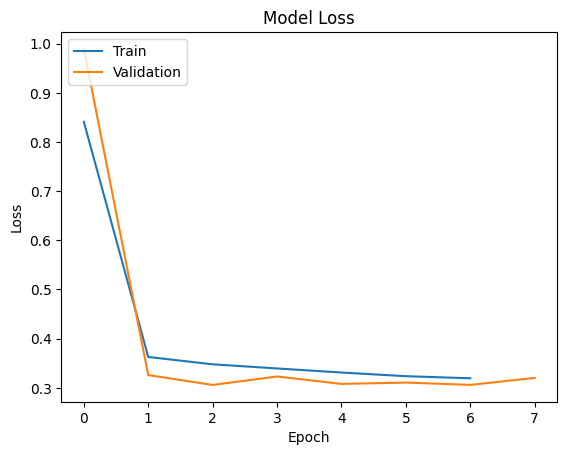

In [64]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()